In [2]:
!pip install hdbscan

  Using cached hdbscan-0.8.26.tar.gz (4.7 MB)
  Installing build dependencies: started    WARNING: Subprocess output does not appear to be encoded as cp1251
  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' 'C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' build_wheel 'C:\Users\3C8A~1\AppData\Local\Temp\tmpzzmzwyhp'
       cwd: C:\Users\Иван\AppData\Local\Temp\pip-install-l6d70ah1\hdbscan
  Complete output (27 lines):
  Error in sitecustomize; set PYTHONVERBOSE for traceback:
  SyntaxError: (unicode error) 'utf-8' codec can't decode byte 0xc8 in position 0: invalid continuation byte (sitecustomize.py, line 21)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\hdbscan
  copying hdbscan\hdbscan_.py -> build\lib.win-amd64-3.8\hdbscan
  copying hdbscan\plots.py -> build\lib.win-amd64-3.8\hdbscan
  copying hdbscan\predict

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10


RANDOM_SEED = 45

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
sensor_data = pd.read_csv('sensor_data.csv').drop(
    ['Unnamed: 0'], axis=1).set_index('date')
sensor_data.index = pd.to_datetime(sensor_data.index)
sensor_data = sensor_data.sort_index()

last_yield_date = pd.to_datetime('2054-12-31')
sensor_data = sensor_data[:last_yield_date]

In [7]:
def create_dataset(X, y, time_steps=1): # создание датасета временных последовательностей
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
from sklearn.preprocessing import StandardScaler
TIME_STEPS=30

In [9]:
def get_anomaly_detection_model(df, fieldname, TIME_STEPS=TIME_STEPS, 
                                verbose=0, quantile_size=.98):
  '''Get anomaly detection model for single col df with datetime index.
    Keyword arguments:
    df: pandas.DataFrame -- dataframe with datetime index and 
    fieldname: string -- name of df argument column for anomaly_detection 
    TIME_STEPS: int -- shape of data for anomaly detection
  '''
  df = pd.DataFrame(df[fieldname]).dropna()
  train_size = int(len(df) * 0.95)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

  scaler = StandardScaler()
  scaler = scaler.fit(train[[fieldname]])

  train[fieldname] = scaler.transform(train[[fieldname]])
  test[fieldname] = scaler.transform(test[[fieldname]])

  X_train, y_train = create_dataset(train[[fieldname]], train[fieldname], TIME_STEPS)
  X_test, y_test = create_dataset(test[[fieldname]], test[fieldname], TIME_STEPS)

  model = keras.Sequential()
  model.add(keras.layers.LSTM(
      units=64, 
      input_shape=(X_train.shape[1], X_train.shape[2])
  ))
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
  model.add(keras.layers.LSTM(units=64, return_sequences=True))
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
  model.compile(loss='mae', optimizer='adam', metrics=['MeanSquaredError'])

  history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=verbose
  )

  X_train_pred = model.predict(X_train)
  train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
  THRESHOLD = np.quantile(train_mae_loss, quantile_size)

  return model, scaler, THRESHOLD

In [10]:
model_lstm, scaler_lstm, THRESHOLD = get_anomaly_detection_model(sensor_data, 'air_temperature', TIME_STEPS=TIME_STEPS, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/15
233/233 [==============================] - 10s 41ms/step - loss: 0.3119 - mean_squared_error: 0.1944 - val_loss: 0.2374 - val_mean_squared_error: 0.1025
Epoch 2/15
233/233 [==============================] - 11s 48ms/step - loss: 0.2458 - mean_squared_error: 0.1096 - val_loss: 0.1967 - val_mean_squared_error: 0.0707
Epoch 3/15
233/233 [==============================] - 9s 38ms/step - loss: 0.1956 - mean_squared_error: 0.0716 - val_loss: 0.1435 - val_mean_squared_error: 0.0397
Epoch 4/15
233/233 [==============================] - 9s 37ms/step - loss: 0.1585 - mean_squared_error: 0.0470 - val_loss: 0.1324 - val_mean_squared_error: 0.0325
Epoch 5/15
233/233 [==============================] - 8s 36ms/step - loss: 0.1484 - mean_squared_error: 0.0404 - val_loss: 0.1263 - val_mean_squared_error: 0.0289
Epoch 6/15
233/233 [==============================] - 8s 36ms/step - loss: 0.1437 - mean_squared_error: 0.0379 - val_loss: 0.1194 - val_mean_squared_error: 0.0265
Epoch 7/15
233/233 [

In [70]:
model_lstm.save('model_lstm')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_lstm/assets


In [ ]:
import pickle
pickle.dump(scaler_lstm, open('scaler_lstm.pkl', 'wb'))

In [ ]:
with open('THRESHOLD.txt', 'w') as f:
  f.write(str(THRESHOLD))

In [12]:
def transform_to_predict_input(data, scaler=scaler_lstm, TIME_STEPS=TIME_STEPS):
  'Transform iterable object with lenght equals or multiplicle to TIME_STEPS for predictoin'
  dlen = len(data)
  if dlen % TIME_STEPS != 0:
    raise ValueError('Data is iterable with TIME_STEPS multiplicity lenght')
  return scaler.transform(np.array(data).reshape(1, dlen)).reshape(dlen // TIME_STEPS, TIME_STEPS, 1)


def check_anomalies(values, model=model_lstm):
  'Check value for anomalousness'
  
  for_prediction = transform_to_predict_input(values)
  predicted = model.predict(for_prediction)
  diff = predicted - for_prediction
  return abs(diff) > THRESHOLD

### Построение моделей для остальных признаков

In [47]:
from copy import deepcopy

In [48]:
def calc_NA_percent(df):
  nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
  idx = nans['percent'] > 0
  return nans[idx]

calc_NA_percent(sensor_data)

,percent
relative_soil_mosture_p3,0.149452
illumination_p4,0.130941
soil_acidity_p2,0.089808
soil_acidity_p3,0.089580
illumination_p2,0.078839
relative_soil_mosture_p1,0.070270
illumination_p5,0.068784
illumination_p1,0.061129
soil_acidity_p4,0.058958
illumination_p3,0.058501


In [49]:
sensor_data_clean = deepcopy(sensor_data)

In [50]:
for il in ['illumination_p1', 'illumination_p2', 'illumination_p3', 
           'illumination_p4', 'illumination_p5']: # p4 много выбросов
  ip_fillna = sensor_data[il][sensor_data[il] < 20].mean()
  sensor_data_clean[il] = sensor_data[il].fillna(ip_fillna)

In [51]:
sensor_data_clean['illumination_p3'].isna().sum()

0

In [52]:
for il in ['relative_soil_mosture_p1', 'relative_soil_mosture_p2', 'relative_soil_mosture_p3',
           'relative_soil_mosture_p4', 'relative_soil_mosture_p5']: 
  ip_fillna = sensor_data[il][sensor_data[il] > 80].mean() # p3 много выбросов
  sensor_data_clean[il] = sensor_data[il].fillna(ip_fillna)

In [53]:
for il in range(1, 6):
  name = 'soil_acidity_p' + str(il)
  ip_fillna = sensor_data[name].mean()
  sensor_data_clean[name] = sensor_data[name].fillna(ip_fillna)

In [54]:
# sensor_data_clean = sensor_data_clean.dropna()

Calculating MinPts: <br> 
1. The larger the data set, the larger the value of MinPts should be
2. If the data set is noisier, choose a larger value of MinPts
3. Generally, MinPts should be greater than or equal to the dimensionality of the data set
4. For 2-dimensional data, use DBSCAN’s default value of MinPts = 4 (Ester et al., 1996).

In [55]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN, approximate_predict

In [56]:
minpts = 8 # шумный датасет с двумя измерениями

In [57]:
def plot_hdbscan_outlier_data(clusterer, df, field):
  labels = clusterer.labels_
  outlier_pos = np.where(labels == -1)[0]
  x = []; y = [];
  for pos in outlier_pos:
      x.append(np.array(df[field])[pos])
      y.append(df[field].index[pos])
      
  plt.plot(df[field].loc[df[field].index], 'k-')
  plt.plot(y,x,'r*', markersize=8)  
  plt.legend([field, 'Anomaly Detected'])
  plt.xlabel('Time Period')
  plt.ylabel(field)
  plt.show()
  print('Outlier ratio: ', len(outlier_pos)/len(df))

In [58]:
sensor_data_clean.columns

Index(['air_temperature', 'relative_soil_mosture_p1', 'illumination_p1',
       'soil_acidity_p1', 'relative_soil_mosture_p2', 'illumination_p2',
       'soil_acidity_p2', 'relative_soil_mosture_p3', 'illumination_p3',
       'soil_acidity_p3', 'relative_soil_mosture_p4', 'illumination_p4',
       'soil_acidity_p4', 'relative_soil_mosture_p5', 'illumination_p5',
       'soil_acidity_p5'],
      dtype='object')

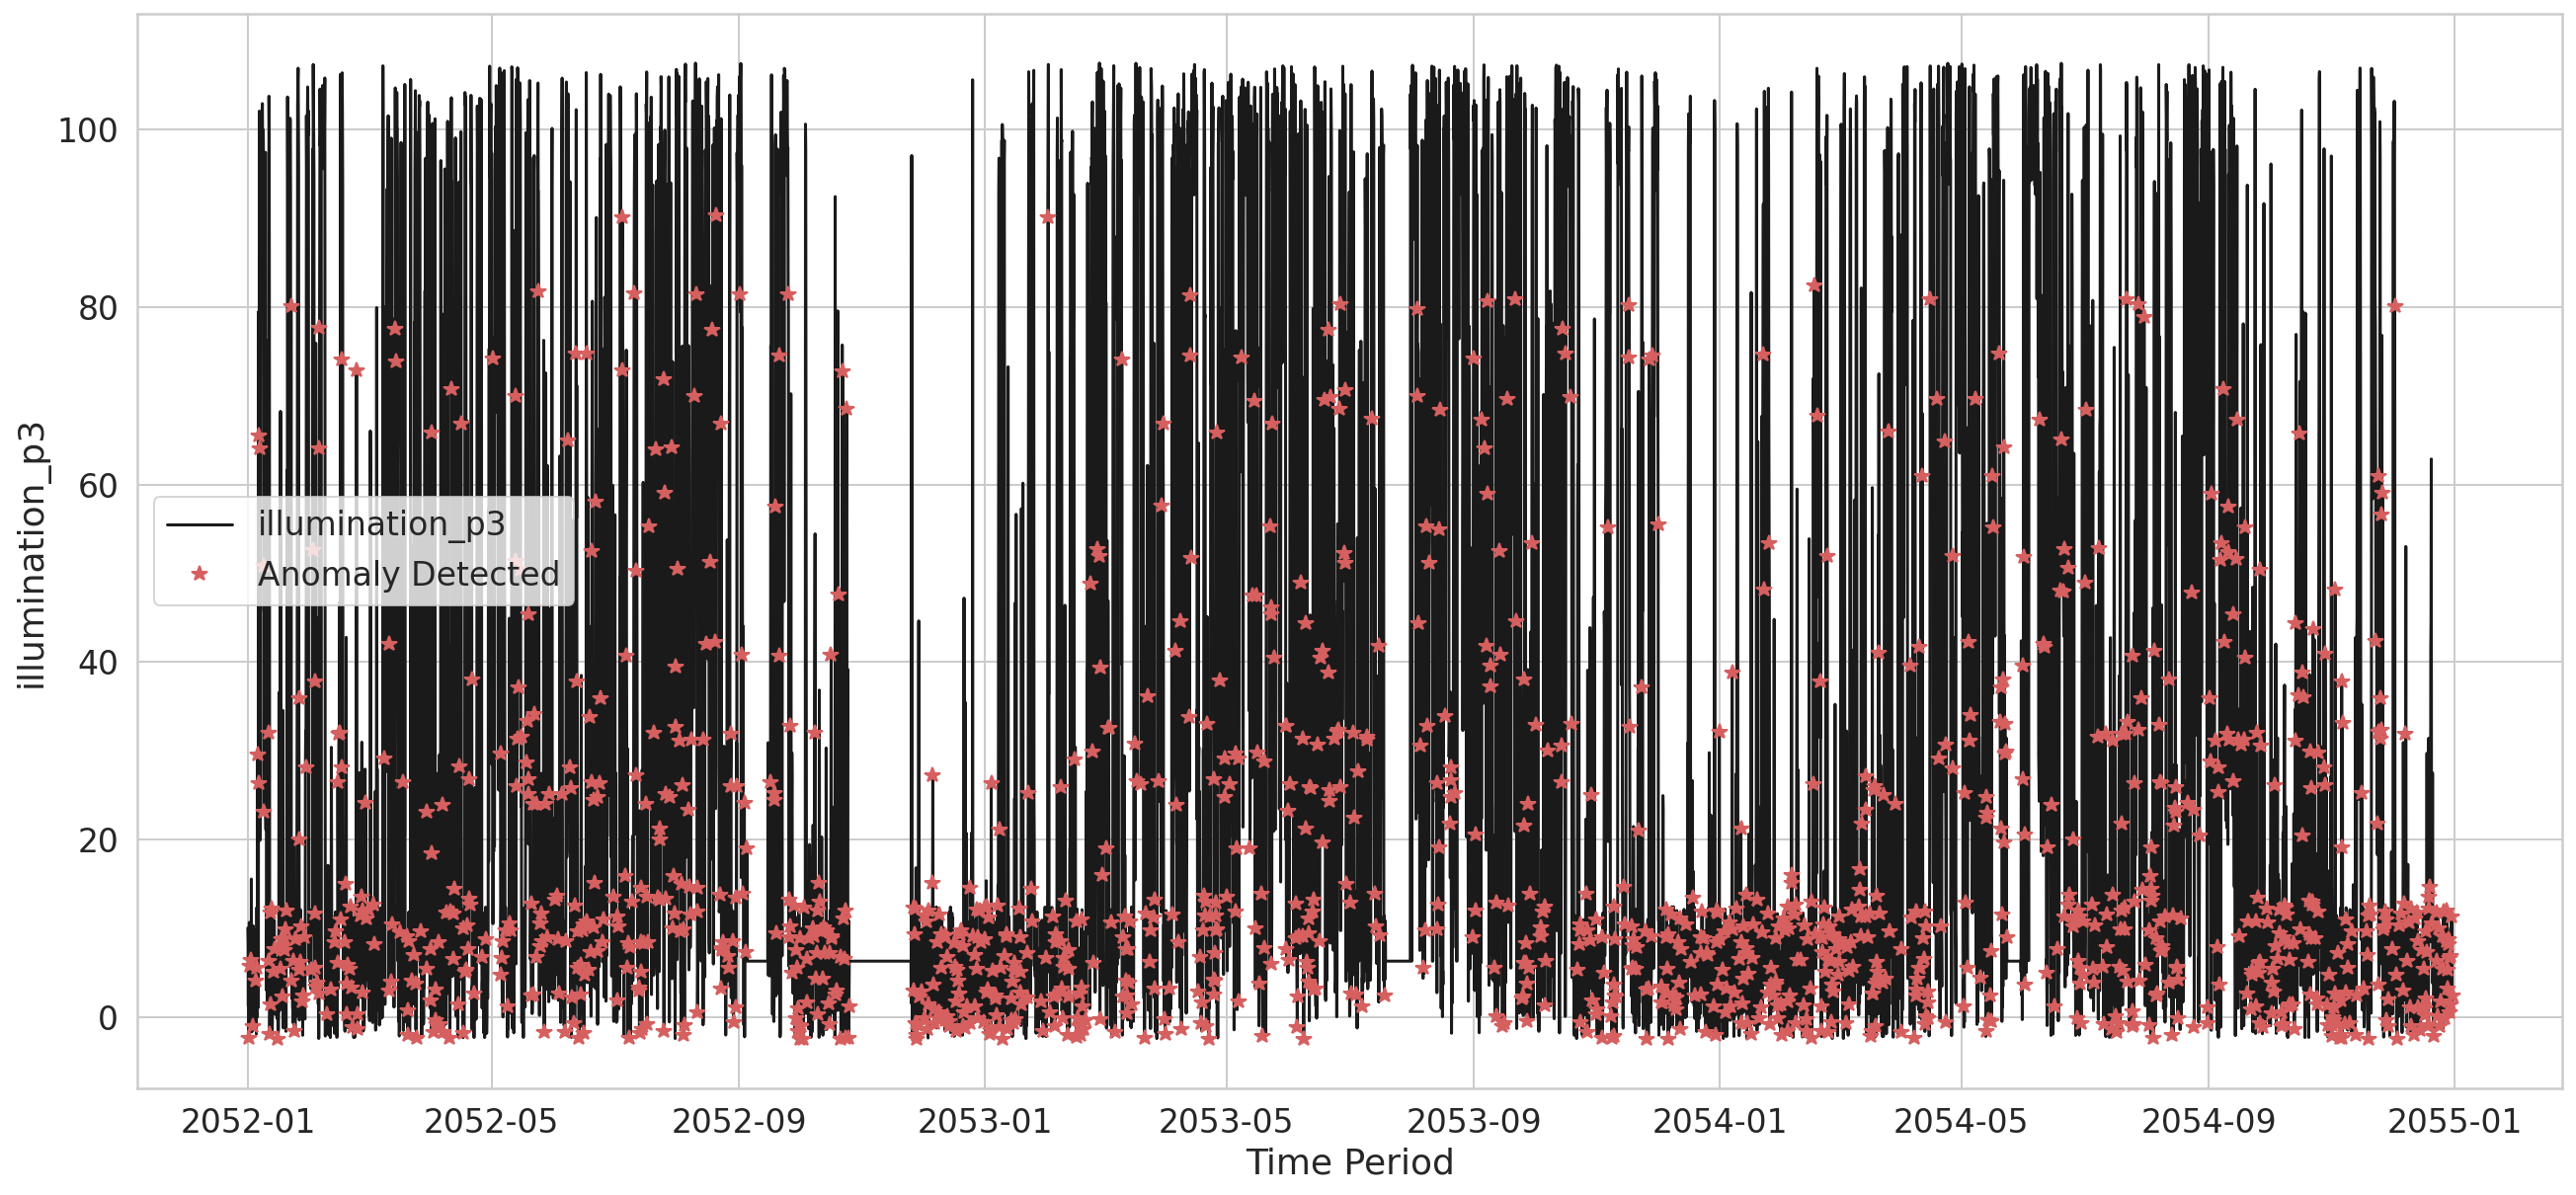

Outlier ratio:  0.15413619744058502


In [59]:
field = 'illumination_p3'
minpts = 8
clusterer = HDBSCAN(minpts, prediction_data=True).fit(np.array(sensor_data_clean[field]).reshape(-1,1))
plot_hdbscan_outlier_data(clusterer, sensor_data_clean, field)

In [60]:
import pickle

In [61]:
clusterer = HDBSCAN(minpts, prediction_data=True).fit(np.array(sensor_data_clean[field]).reshape(-1,1))

In [62]:
np.array(sensor_data_clean[field]).reshape(-1,1).shape

(8752, 1)

In [63]:
def train_pred_clusterer(data, minpts=8):
  train = np.array(data).reshape(-1, 1)
  clusterer = HDBSCAN(minpts, prediction_data=True)
  return clusterer.fit(train)

In [64]:
def save_model(model, filename):
  with open(filename, 'wb') as f:
    pickle.dump(model, f)

def load_model(filename):
  with open(filename, 'rb'):
    return pickle.load(f)

In [65]:
mnames = list(sensor_data_clean.columns)[1:]

In [66]:
mnames

['relative_soil_mosture_p1',
 'illumination_p1',
 'soil_acidity_p1',
 'relative_soil_mosture_p2',
 'illumination_p2',
 'soil_acidity_p2',
 'relative_soil_mosture_p3',
 'illumination_p3',
 'soil_acidity_p3',
 'relative_soil_mosture_p4',
 'illumination_p4',
 'soil_acidity_p4',
 'relative_soil_mosture_p5',
 'illumination_p5',
 'soil_acidity_p5']

In [67]:
sensor_data_clean['relative_soil_mosture_p3'].isna().sum()

0

In [68]:
# train_pred_clusterer(sensor_data_clean['relative_soil_mosture_p3'])

In [69]:
for name in mnames:
  print(name)
  clusterer = train_pred_clusterer(sensor_data_clean[name])
  save_model(clusterer, 'clusterers/' + name + '.pkl')

relative_soil_mosture_p1
illumination_p1
soil_acidity_p1
relative_soil_mosture_p2
illumination_p2
soil_acidity_p2
relative_soil_mosture_p3
illumination_p3
soil_acidity_p3
relative_soil_mosture_p4
illumination_p4
soil_acidity_p4
relative_soil_mosture_p5
illumination_p5
soil_acidity_p5
